# AN2DL Challenge 2 — Path Foundation (TF-Keras embeddings on CPU) + PyTorch 4-head OVR classifier
Stessa struttura del tuo notebook, ma:
- patch drop un po' più selettivo
- testa più robusta: trunk piccolo + 4 teste (una per classe, one-vs-rest)
- bilanciamento pos/neg: `pos_weight` per ogni testa + sampler opzionale
- fix di celle “pericolose” (niente cleanup automatico che distrugge oggetti)


In [78]:

# ============================================================
# CELL 0 - INSTALL (Lion)
# ============================================================
!pip -q install lion-pytorch


In [79]:

# ============================================================
# CELL 0B - FORCE TENSORFLOW ON CPU (MUST RUN BEFORE ANY tf import)
# ============================================================
import os
os.environ["TF_CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("TF_CUDA_VISIBLE_DEVICES =", os.environ.get("TF_CUDA_VISIBLE_DEVICES"))
print("CUDA_VISIBLE_DEVICES    =", os.environ.get("CUDA_VISIBLE_DEVICES", "NOT SET (PyTorch can use GPUs)"))


TF_CUDA_VISIBLE_DEVICES = -1
CUDA_VISIBLE_DEVICES    = NOT SET (PyTorch can use GPUs)


In [80]:

# ============================================================
# CELL 1 - IMPORTS + SEED + DEVICE + CLEANUP
# ============================================================
import gc, math, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"Torch device: {device} | n_gpu: {n_gpu}")
if n_gpu > 0:
    for i in range(n_gpu):
        p = torch.cuda.get_device_properties(i)
        print(f"  GPU {i}: {p.name} | {p.total_memory/1e9:.1f} GB")

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        try:
            torch.cuda.ipc_collect()
        except Exception:
            pass


Torch device: cuda | n_gpu: 2
  GPU 0: Tesla T4 | 15.8 GB
  GPU 1: Tesla T4 | 15.8 GB


In [81]:

# ============================================================
# CELL 2 - CONFIG + PATHS
# ============================================================
import os

TRAIN_LABELS_PATH = "/kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original/train/train_labels.csv"
TRAIN_IMAGES_ROOT = "/kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original/train/images"
TEST_IMAGES_ROOT  = "/kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original/test/images"

WORKDIR = "/kaggle/working"
SUBMISSION_PATH = os.path.join(WORKDIR, "submission.csv")
CKPT_DIR = os.path.join(WORKDIR, "ovr4_ckpts")
os.makedirs(CKPT_DIR, exist_ok=True)

TRAIN_EMB_PATH = os.path.join(WORKDIR, "train_embeddings.npz")
VAL_EMB_PATH   = os.path.join(WORKDIR, "val_embeddings.npz")
TEST_EMB_PATH  = os.path.join(WORKDIR, "test_embeddings.npz")

MODEL_NAME = "google/path-foundation"

IMG_SIZE        = 224
PATCH_SIZE      = 224
PATCH_STRIDE    = 112
DROP_LAST_PATCH = False

# patch drop: leggermente più selettivo
USE_BLACK_FILTER = True
TOPK_IF_TOO_MANY = 12          # era 24 nel tuo file
FORCE_AT_LEAST_ONE_PATCH = True

TF_BATCH = 64  # TF forward batch on CPU

BATCH_SIZE_HEAD = 2048 if n_gpu >= 2 else 1024
NUM_WORKERS = 0
PIN_MEMORY  = torch.cuda.is_available()
PERSISTENT_WORKERS = False
print("OK config")
print(f"PATCH_STRIDE={PATCH_STRIDE} | TOPK={TOPK_IF_TOO_MANY} | BATCH_SIZE_HEAD={BATCH_SIZE_HEAD}")


OK config
PATCH_STRIDE=112 | TOPK=12 | BATCH_SIZE_HEAD=2048


In [82]:

# ============================================================
# CELL 3 - LOAD TF-KERAS PATH MODEL (TF ON CPU)
# ============================================================
import tensorflow as tf
from huggingface_hub import login, from_pretrained_keras

try:
    tf.config.set_visible_devices([], "GPU")
except Exception as e:
    print("set_visible_devices warning:", e)

print("TF devices:", tf.config.list_physical_devices())

login(new_session=False)

print("Loading Path Foundation:", MODEL_NAME)
path_model = from_pretrained_keras(MODEL_NAME)

dummy = tf.zeros([1, IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)
out = path_model(dummy, training=False)
EMB_DIM = int(out.shape[-1])
print("Path output shape:", out.shape, "| EMB_DIM =", EMB_DIM)


TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Loading Path Foundation: google/path-foundation


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Path output shape: (1, 384) | EMB_DIM = 384


In [83]:

# ============================================================
# CELL 4 - READ CSV + LABEL MAP (sanity print)
# ============================================================
df = pd.read_csv(TRAIN_LABELS_PATH)

IMG_COL   = df.columns[0]
LABEL_COL = df.columns[1]

unique_labels = sorted(df[LABEL_COL].unique())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}

df["label_id"] = df[LABEL_COL].map(label2id).astype(int)
LABEL_COL_NUM = "label_id"
NUM_CLASSES = len(unique_labels)

df["img_path"] = df[IMG_COL].apply(lambda x: os.path.join(TRAIN_IMAGES_ROOT, str(x)))

print("IMG_COL:", IMG_COL, "| LABEL_COL:", LABEL_COL, "| NUM_CLASSES:", NUM_CLASSES)
print("Labels:", unique_labels)
print("label2id:", label2id)
print("id2label:", id2label)

display(df.head())


IMG_COL: sample_index | LABEL_COL: label | NUM_CLASSES: 4
Labels: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
label2id: {'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}
id2label: {0: 'HER2(+)', 1: 'Luminal A', 2: 'Luminal B', 3: 'Triple negative'}


,sample_index,label,label_id,img_path
0,img_0000.png,Triple negative,3,/kaggle/input/kagglejson/an2dl_challenge2_orig...
1,img_0001.png,Luminal B,2,/kaggle/input/kagglejson/an2dl_challenge2_orig...
2,img_0002.png,Luminal B,2,/kaggle/input/kagglejson/an2dl_challenge2_orig...
3,img_0003.png,Luminal B,2,/kaggle/input/kagglejson/an2dl_challenge2_orig...
4,img_0004.png,Luminal B,2,/kaggle/input/kagglejson/an2dl_challenge2_orig...


In [84]:
# ============================================================
# CELL 4B - DATASET OVERVIEW (IMAGE-LEVEL)
#   -> Put right after CELL 4
# ============================================================
import numpy as np
import pandas as pd

assert "df" in globals() and "LABEL_COL_NUM" in globals()

print("\n=== Dataset Overview (image-level) ===")
print("Total images:", len(df))
counts_all = df[LABEL_COL_NUM].value_counts().sort_index()
for k, v in counts_all.items():
    print(f"  {k} ({id2label[k]}): {v}")

print("\nClass %:")
pct = (counts_all / counts_all.sum() * 100).round(2)
for k, v in pct.items():
    print(f"  {k} ({id2label[k]}): {v}%")



=== Dataset Overview (image-level) ===
Total images: 691
  0 (HER2(+)): 189
  1 (Luminal A): 205
  2 (Luminal B): 220
  3 (Triple negative): 77

Class %:
  0 (HER2(+)): 27.35%
  1 (Luminal A): 29.67%
  2 (Luminal B): 31.84%
  3 (Triple negative): 11.14%


In [85]:

# ============================================================
# CELL 5 - PATCH UTILS + MORE SELECTIVE BACKGROUND/TISSUE FILTER
# ============================================================
import cv2

def pad_reflect_to_size(img_np: np.ndarray, target_h: int, target_w: int) -> np.ndarray:
    h, w, _ = img_np.shape
    pad_bottom = max(0, target_h - h)
    pad_right  = max(0, target_w - w)
    if pad_bottom == 0 and pad_right == 0:
        return img_np
    return cv2.copyMakeBorder(img_np, 0, pad_bottom, 0, pad_right, borderType=cv2.BORDER_REFLECT_101)

def compute_grid(H, W, patch_size, stride, drop_last_patch):
    if drop_last_patch:
        xs = list(range(0, W - patch_size + 1, stride)) if W >= patch_size else []
        ys = list(range(0, H - patch_size + 1, stride)) if H >= patch_size else []
    else:
        n_cols = max(1, math.ceil((W - patch_size) / stride) + 1) if W > patch_size else 1
        n_rows = max(1, math.ceil((H - patch_size) / stride) + 1) if H > patch_size else 1
        xs = [min(k * stride, max(0, W - patch_size)) for k in range(n_cols)]
        ys = [min(k * stride, max(0, H - patch_size)) for k in range(n_rows)]
    return xs, ys

TF_INPUT_SIZE = 224
TISSUE_DOWNSAMPLE = 96

# HSV heuristics (più selettivo)
TISSUE_S_THR = 22
TISSUE_V_MAX = 242

BG_S_MAX = 10
BG_V_MIN = 246

INK_V_MAX = 85
INK_S_MIN = 28

MIN_TISSUE_FRAC = 0.020     # era 0.010
MAX_INK_FRAC    = 0.220     # era 0.250
MIN_SCORE_KEEP  = 0.010     # nuovo: scarta patch "quasi vuote"

def _resize_rgb(patch_rgb: np.ndarray, out_size: int = TF_INPUT_SIZE) -> np.ndarray:
    h, w = patch_rgb.shape[:2]
    if h == out_size and w == out_size:
        return patch_rgb
    interp = cv2.INTER_AREA if (h > out_size or w > out_size) else cv2.INTER_LINEAR
    return cv2.resize(patch_rgb, (out_size, out_size), interpolation=interp)

def _hsv_small(patch_rgb: np.ndarray):
    hsv = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2HSV)
    if hsv.shape[0] != TISSUE_DOWNSAMPLE or hsv.shape[1] != TISSUE_DOWNSAMPLE:
        hsv = cv2.resize(hsv, (TISSUE_DOWNSAMPLE, TISSUE_DOWNSAMPLE), interpolation=cv2.INTER_AREA)
    return hsv

def _tissue_ink_bg_frac(patch_rgb_224: np.ndarray):
    hsv = _hsv_small(patch_rgb_224)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]

    tissue = (S > TISSUE_S_THR) & (V < TISSUE_V_MAX)
    ink    = (V < INK_V_MAX) & (S > INK_S_MIN)
    bg     = (S < BG_S_MAX) & (V > BG_V_MIN)

    return float(tissue.mean()), float(ink.mean()), float(bg.mean())

def patch_black_score(patch_rgb_224: np.ndarray) -> float:
    tissue_frac, ink_frac, bg_frac = _tissue_ink_bg_frac(patch_rgb_224)
    return float(tissue_frac - 0.70 * ink_frac + 0.03 * (1.0 - bg_frac))

def is_black_patch(patch_rgb_224: np.ndarray) -> bool:
    tissue_frac, ink_frac, bg_frac = _tissue_ink_bg_frac(patch_rgb_224)
    score = patch_black_score(patch_rgb_224)

    if tissue_frac < MIN_TISSUE_FRAC:
        return True
    if score < MIN_SCORE_KEEP:
        return True
    if (ink_frac > MAX_INK_FRAC) and (tissue_frac < 0.25):
        return True
    if (bg_frac > 0.985) and (tissue_frac < 0.04):
        return True
    return False


In [86]:

# ============================================================
# CELL 6 - BUILD PATCH COORDS PER IMAGE
# ============================================================
def build_patch_index(
    df_in,
    img_root,
    img_col,
    patch_size=224,
    stride=224,
    drop_last_patch=False,
    use_black_filter=True,
    topk=12,
    force_one=True,
    tf_input_size=224,
):
    df_in = df_in.reset_index(drop=True)
    valid_rows = []
    coords = []

    total_candidates = 0
    dropped_black = 0
    forced_imgs = 0

    for i in range(len(df_in)):
        img_name = str(df_in.iloc[i][img_col])
        img_path = os.path.join(img_root, img_name)
        if not os.path.isfile(img_path):
            continue

        try:
            img_np = np.array(Image.open(img_path).convert("RGB"))
        except Exception:
            continue

        H, W = img_np.shape[:2]
        xs, ys = compute_grid(H, W, patch_size, stride, drop_last_patch)

        cand = []
        all_cand = []

        for y in ys:
            for x in xs:
                total_candidates += 1

                patch = img_np[y:y+patch_size, x:x+patch_size, :]
                if not drop_last_patch:
                    patch = pad_reflect_to_size(patch, patch_size, patch_size)

                patch_224 = _resize_rgb(patch, tf_input_size)
                score = patch_black_score(patch_224)
                all_cand.append((score, x, y))

                if use_black_filter and is_black_patch(patch_224):
                    dropped_black += 1
                    continue

                cand.append((score, x, y))

        if len(cand) == 0 and force_one and len(all_cand) > 0:
            all_cand.sort(key=lambda t: t[0], reverse=True)
            cand = [all_cand[0]]
            forced_imgs += 1

        if len(cand) == 0:
            continue

        cand.sort(key=lambda t: t[0], reverse=True)
        if topk is not None and len(cand) > topk:
            cand = cand[:topk]

        valid_rows.append(df_in.iloc[i])
        img_id_new = len(valid_rows) - 1
        for _, x, y in cand:
            coords.append((img_id_new, x, y))

    df_out = pd.DataFrame(valid_rows).reset_index(drop=True)

    print(f"[build_patch_index] images: {len(df_out)} | patches kept: {len(coords)}")
    if total_candidates > 0:
        print(f"[build_patch_index] black dropped: {dropped_black}/{total_candidates} ({dropped_black/total_candidates:.1%})")
    if forced_imgs > 0:
        print(f"[build_patch_index] fallback forced 1 patch for {forced_imgs} images")

    return df_out, coords



=== Example 1/3 ===
File: img_0494.png
Grid patches: 90 | kept (pre-topk): 72 | dropped: 18 | kept (after topk): 12
Kept score range: 0.0621 .. 0.5260


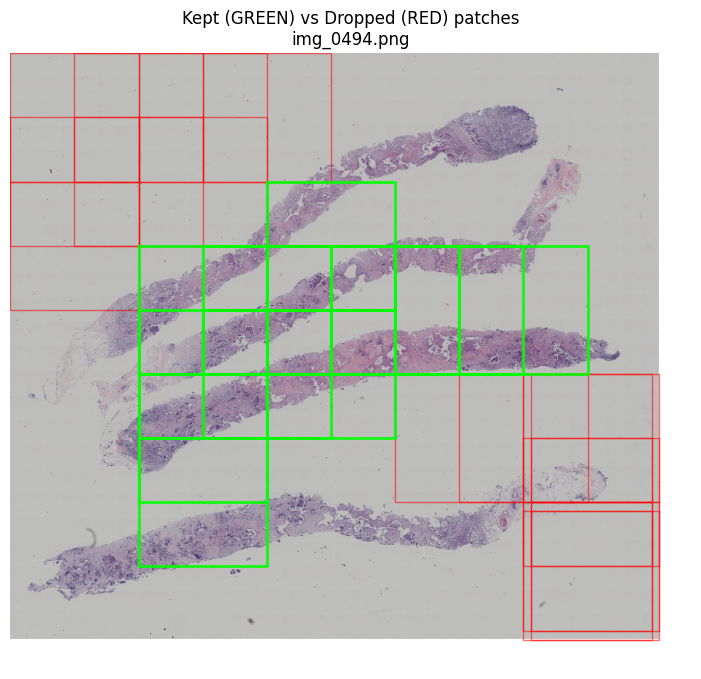


=== Example 2/3 ===
File: img_0426.png
Grid patches: 81 | kept (pre-topk): 34 | dropped: 47 | kept (after topk): 12
Kept score range: 0.0501 .. 0.4552


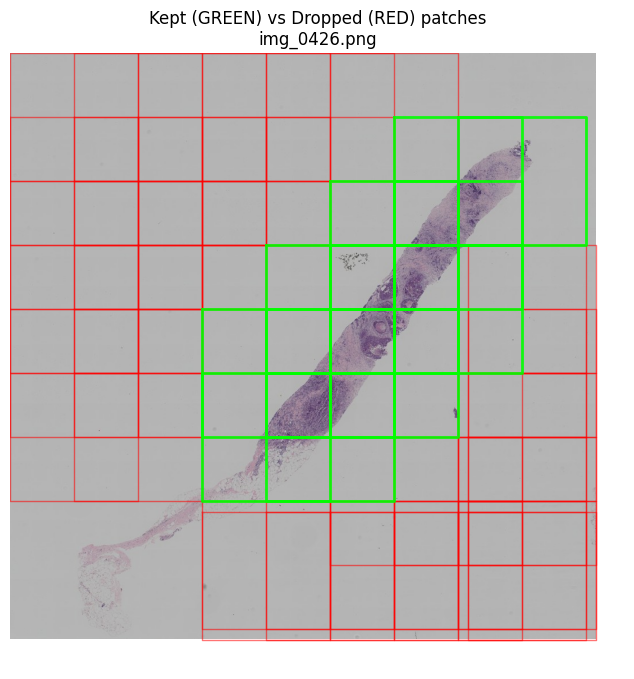


=== Example 3/3 ===
File: img_0163.png
Grid patches: 90 | kept (pre-topk): 45 | dropped: 45 | kept (after topk): 12
Kept score range: 0.0434 .. 0.5850


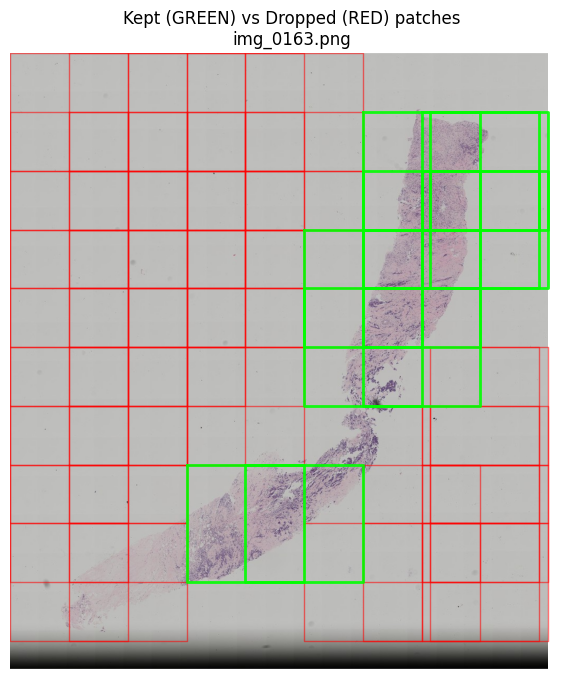

In [87]:
# ============================================================
# CELL 6B - VISUALIZE KEPT vs DROPPED PATCHES (random images)
# ============================================================
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def _get_all_grid_patches_for_image(img_path, patch_size, stride, drop_last_patch):
    img_np = np.array(Image.open(img_path).convert("RGB"))
    H, W = img_np.shape[:2]
    xs, ys = compute_grid(H, W, patch_size, stride, drop_last_patch)

    items = []
    for y in ys:
        for x in xs:
            patch = img_np[y:y+patch_size, x:x+patch_size, :]
            if not drop_last_patch:
                patch = pad_reflect_to_size(patch, patch_size, patch_size)
            patch_224 = _resize_rgb(patch, TF_INPUT_SIZE)
            drop = is_black_patch(patch_224) if USE_BLACK_FILTER else False
            score = patch_black_score(patch_224)
            items.append((x, y, drop, score))
    return img_np, items

def _draw_rect(ax, x, y, ps, color, lw=2, alpha=0.9):
    ax.plot([x, x+ps, x+ps, x, x], [y, y, y+ps, y+ps, y],
            linewidth=lw, alpha=alpha, color=color)

def show_kept_dropped_random(df_in, img_root, img_col, n_show=3, seed=42, topk=TOPK_IF_TOO_MANY):
    rnd = random.Random(seed)
    idxs = list(range(len(df_in)))
    rnd.shuffle(idxs)
    idxs = idxs[:n_show]

    for k, i in enumerate(idxs, 1):
        img_name = str(df_in.iloc[i][img_col])
        img_path = os.path.join(img_root, img_name)
        if not os.path.isfile(img_path):
            print("Missing:", img_path)
            continue

        img_np, items = _get_all_grid_patches_for_image(
            img_path, PATCH_SIZE, PATCH_STRIDE, DROP_LAST_PATCH
        )

        kept = [(x,y,sc) for (x,y,drop,sc) in items if not drop]
        dropped = [(x,y,sc) for (x,y,drop,sc) in items if drop]

        kept_sorted = sorted(kept, key=lambda t: t[2], reverse=True)
        kept_topk = kept_sorted[:topk] if (topk is not None and len(kept_sorted) > topk) else kept_sorted

        # quick stats
        print(f"\n=== Example {k}/{n_show} ===")
        print("File:", img_name)
        print(f"Grid patches: {len(items)} | kept (pre-topk): {len(kept)} | dropped: {len(dropped)} | kept (after topk): {len(kept_topk)}")
        if len(kept_sorted) > 0:
            print(f"Kept score range: {kept_sorted[-1][2]:.4f} .. {kept_sorted[0][2]:.4f}")

        plt.figure(figsize=(10, 8))
        plt.imshow(img_np)
        plt.title(f"Kept (GREEN) vs Dropped (RED) patches\n{img_name}")
        plt.axis("off")

        # draw dropped first (red, thinner)
        for (x,y,sc) in dropped:
            _draw_rect(plt.gca(), x, y, PATCH_SIZE, color="red", lw=1, alpha=0.55)

        # draw kept-after-topk (green, thicker)
        for (x,y,sc) in kept_topk:
            _draw_rect(plt.gca(), x, y, PATCH_SIZE, color="lime", lw=2, alpha=0.90)

        plt.show()

# ---- run on train_df or val_df (choose one) ----
# Esempio: mostra 3 immagini random dal train split originale
show_kept_dropped_random(train_df, TRAIN_IMAGES_ROOT, IMG_COL, n_show=3, seed=SEED, topk=TOPK_IF_TOO_MANY)


In [88]:

# ============================================================
# CELL 7 - SPLIT (IMAGE-LEVEL STRATIFIED)
# ============================================================
train_df, val_df = train_test_split(
    df,
    stratify=df[LABEL_COL_NUM],
    test_size=0.20,
    random_state=SEED,
)
print("Train images:", len(train_df), "| Val images:", len(val_df))


Train images: 552 | Val images: 139


In [89]:

# ============================================================
# CELL 8 - EXTRACT TF-KERAS EMBEDDINGS (PATCH-LEVEL) + CACHE NPZ
# ============================================================
from tqdm.auto import tqdm

def _patch_to_model_input(patch_rgb_224: np.ndarray) -> np.ndarray:
    return patch_rgb_224.astype(np.float32) / 255.0

def _augment_patch_rgb(patch_rgb: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    if rng.random() < 0.5:
        patch_rgb = np.flip(patch_rgb, axis=1)
    if rng.random() < 0.5:
        patch_rgb = np.flip(patch_rgb, axis=0)
    k = int(rng.integers(0, 4))
    if k:
        patch_rgb = np.rot90(patch_rgb, k, axes=(0, 1))
    return patch_rgb.copy()

@tf.function(reduce_retracing=True)
def tf_forward(batch_nhwc):
    return path_model(batch_nhwc, training=False)

def extract_and_cache(
    df_in,
    coords,
    img_root,
    out_npz_path,
    has_labels: bool,
    apply_aug: bool = False,
    aug_prob: float = 0.7,
    seed: int = 42,
):
    feats_list  = []
    labels_list = []
    imgid_list  = []

    filenames = df_in[IMG_COL].astype(str).tolist()

    by_img = [[] for _ in range(len(df_in))]
    for (img_id, x, y) in coords:
        if 0 <= img_id < len(by_img):
            by_img[img_id].append((x, y))

    rng = np.random.default_rng(seed)

    for img_id in tqdm(range(len(df_in)), desc=f"Extract -> {os.path.basename(out_npz_path)}"):
        img_name = filenames[img_id]
        img_path = os.path.join(img_root, img_name)

        try:
            img_np = np.array(Image.open(img_path).convert("RGB"))
        except Exception:
            continue

        patches = []
        for (x, y) in by_img[img_id]:
            patch = img_np[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :]
            if patch.size == 0:
                continue
            if not DROP_LAST_PATCH:
                patch = pad_reflect_to_size(patch, PATCH_SIZE, PATCH_SIZE)

            if apply_aug and (rng.random() < aug_prob):
                patch = _augment_patch_rgb(patch, rng)

            patch_224 = _resize_rgb(patch, TF_INPUT_SIZE)
            patches.append(_patch_to_model_input(patch_224))

        if len(patches) == 0:
            continue

        for s in range(0, len(patches), TF_BATCH):
            batch = np.stack(patches[s:s+TF_BATCH], axis=0).astype(np.float32, copy=False)
            emb = tf_forward(tf.convert_to_tensor(batch)).numpy()

            feats_list.append(emb.astype(np.float16, copy=False))
            imgid_list.append(np.full((emb.shape[0],), img_id, dtype=np.int64))

            if has_labels:
                ylab = int(df_in.iloc[img_id][LABEL_COL_NUM])
                labels_list.append(np.full((emb.shape[0],), ylab, dtype=np.int64))

        cleanup_memory()

    feats   = np.concatenate(feats_list, axis=0) if len(feats_list) else np.zeros((0, EMB_DIM), np.float16)
    img_ids = np.concatenate(imgid_list, axis=0) if len(imgid_list) else np.zeros((0,), np.int64)

    if has_labels:
        labels = np.concatenate(labels_list, axis=0) if len(labels_list) else np.zeros((0,), np.int64)
        np.savez_compressed(out_npz_path, feats=feats, labels=labels, img_ids=img_ids,
                            filenames=np.array(filenames, dtype=object))
    else:
        np.savez_compressed(out_npz_path, feats=feats, img_ids=img_ids,
                            filenames=np.array(filenames, dtype=object))

    print("Saved:", out_npz_path, "| feats:", feats.shape)
    return out_npz_path

# --- build indices ---
train_df2, train_coords = build_patch_index(
    train_df, TRAIN_IMAGES_ROOT, IMG_COL,
    patch_size=PATCH_SIZE, stride=PATCH_STRIDE, drop_last_patch=DROP_LAST_PATCH,
    use_black_filter=USE_BLACK_FILTER, topk=TOPK_IF_TOO_MANY, force_one=FORCE_AT_LEAST_ONE_PATCH
)
val_df2, val_coords = build_patch_index(
    val_df, TRAIN_IMAGES_ROOT, IMG_COL,
    patch_size=PATCH_SIZE, stride=PATCH_STRIDE, drop_last_patch=DROP_LAST_PATCH,
    use_black_filter=USE_BLACK_FILTER, topk=TOPK_IF_TOO_MANY, force_one=FORCE_AT_LEAST_ONE_PATCH
)

num_train_images = len(train_df2)
num_val_images   = len(val_df2)

if not os.path.isfile(TRAIN_EMB_PATH):
    extract_and_cache(train_df2, train_coords, TRAIN_IMAGES_ROOT, TRAIN_EMB_PATH,
                      has_labels=True, apply_aug=True, aug_prob=0.7, seed=SEED)
else:
    print("Using cached:", TRAIN_EMB_PATH)

if not os.path.isfile(VAL_EMB_PATH):
    extract_and_cache(val_df2, val_coords, TRAIN_IMAGES_ROOT, VAL_EMB_PATH,
                      has_labels=True, apply_aug=False, seed=SEED)
else:
    print("Using cached:", VAL_EMB_PATH)


[build_patch_index] images: 469 | patches kept: 5617
[build_patch_index] black dropped: 30924/56016 (55.2%)
[build_patch_index] fallback forced 1 patch for 1 images
[build_patch_index] images: 112 | patches kept: 1336
[build_patch_index] black dropped: 7557/13392 (56.4%)
Using cached: /kaggle/working/train_embeddings.npz
Using cached: /kaggle/working/val_embeddings.npz


In [90]:
# ============================================================
# CELL 8B - PATCH SELECTION STATS (TOPK + FILTER effect)
# ============================================================
import numpy as np

def patch_stats(coords, n_images, name=""):
    ids = np.array([c[0] for c in coords], dtype=np.int64)
    cnt = np.bincount(ids, minlength=n_images)
    print(f"\n=== Patch stats: {name} ===")
    print("Images:", n_images)
    print("Total patches:", int(cnt.sum()))
    print("Patches/img: mean={:.2f} | std={:.2f} | min={} | p25={} | med={} | p75={} | max={}".format(
        float(cnt.mean()), float(cnt.std()),
        int(cnt.min()), int(np.percentile(cnt, 25)), int(np.percentile(cnt, 50)),
        int(np.percentile(cnt, 75)), int(cnt.max())
    ))

assert "train_coords" in globals() and "val_coords" in globals()
assert "num_train_images" in globals() and "num_val_images" in globals()

patch_stats(train_coords, num_train_images, "TRAIN")
patch_stats(val_coords,   num_val_images,   "VAL")



=== Patch stats: TRAIN ===
Images: 469
Total patches: 5617
Patches/img: mean=11.98 | std=0.51 | min=1 | p25=12 | med=12 | p75=12 | max=12

=== Patch stats: VAL ===
Images: 112
Total patches: 1336
Patches/img: mean=11.93 | std=0.75 | min=4 | p25=12 | med=12 | p75=12 | max=12


In [91]:
# ============================================================
# CELL 9 - LOAD EMBEDDINGS -> BAG (MIL) DATASET/LOADERS
#   - ogni sample = 1 immagine ("bag") con N patch embeddings
#   - train: random patch dropout + noise su embedding (anti-overfit)
# ============================================================
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

train_npz = np.load(TRAIN_EMB_PATH, allow_pickle=True)
val_npz   = np.load(VAL_EMB_PATH, allow_pickle=True)

Xtr = train_npz["feats"].astype(np.float32)
ytr_patch = train_npz["labels"].astype(np.int64)   # patch label (uguale per immagine nel file)
idtr = train_npz["img_ids"].astype(np.int64)

Xva = val_npz["feats"].astype(np.float32)
yva_patch = val_npz["labels"].astype(np.int64)
idva = val_npz["img_ids"].astype(np.int64)

print("Train patches:", Xtr.shape, "| Val patches:", Xva.shape)

# ---- build contiguous segments per image (sorting by img_id) ----
def build_segments(X, y_patch, img_ids):
    order = np.argsort(img_ids)
    Xs = X[order]
    ys = y_patch[order]
    ids = img_ids[order]

    uniq, start_idx = np.unique(ids, return_index=True)
    start_idx = start_idx.astype(np.int64)
    end_idx = np.r_[start_idx[1:], np.array([len(ids)], dtype=np.int64)]

    # image label = majority (qui è quasi sempre costante)
    y_img = []
    for s, e in zip(start_idx, end_idx):
        vals, cnt = np.unique(ys[s:e], return_counts=True)
        y_img.append(int(vals[np.argmax(cnt)]))
    y_img = np.array(y_img, dtype=np.int64)

    return Xs, ys, ids, uniq.astype(np.int64), start_idx, end_idx, y_img

Xtr_s, ytr_s, idtr_s, img_tr, st_tr, en_tr, yimg_tr = build_segments(Xtr, ytr_patch, idtr)
Xva_s, yva_s, idva_s, img_va, st_va, en_va, yimg_va = build_segments(Xva, yva_patch, idva)

num_train_images = len(img_tr)
num_val_images   = len(img_va)
print("Train images:", num_train_images, "| Val images:", num_val_images)

# ---- MIL bag dataset ----
KEEP_PATCH_FRAC_TRAIN = 0.5   # patch dropout dentro il bag (anti-overfit)
MIN_PATCHES_KEEP      = 3
EMB_NOISE_STD         = 0.05   # rumore su embedding (anti-overfit)

class BagEmbDataset(Dataset):
    def __init__(self, Xs, st, en, y_img=None, train_mode=False, seed=42):
        self.Xs = Xs
        self.st = st
        self.en = en
        self.y_img = y_img
        self.train_mode = train_mode
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.st)

    def __getitem__(self, idx):
        s = int(self.st[idx]); e = int(self.en[idx])
        bag = self.Xs[s:e]  # (P,D)

        if self.train_mode:
            P = bag.shape[0]
            if P > MIN_PATCHES_KEEP:
                k = max(MIN_PATCHES_KEEP, int(np.ceil(P * KEEP_PATCH_FRAC_TRAIN)))
                sel = self.rng.choice(P, size=k, replace=False)
                bag = bag[sel]

            if EMB_NOISE_STD > 0:
                noise = self.rng.normal(0.0, EMB_NOISE_STD, size=bag.shape).astype(np.float32)
                bag = bag + noise

        bag_t = torch.from_numpy(bag).float()
        if self.y_img is None:
            return bag_t, idx  # idx = image index
        return bag_t, int(self.y_img[idx]), idx

def collate_bags(batch):
    # batch: list of (bag, y, idx) oppure (bag, idx)
    has_label = (len(batch[0]) == 3)

    bags = [b[0] for b in batch]
    lengths = torch.tensor([x.shape[0] for x in bags], dtype=torch.long)
    B = len(bags)
    Pmax = int(lengths.max().item())
    D = int(bags[0].shape[1])

    X = torch.zeros((B, Pmax, D), dtype=torch.float32)
    mask = torch.zeros((B, Pmax), dtype=torch.bool)
    for i, bag in enumerate(bags):
        p = bag.shape[0]
        X[i, :p] = bag
        mask[i, :p] = True

    if has_label:
        y = torch.tensor([b[1] for b in batch], dtype=torch.long)
        idx = torch.tensor([b[2] for b in batch], dtype=torch.long)
        return X, mask, y, idx
    else:
        idx = torch.tensor([b[1] for b in batch], dtype=torch.long)
        return X, mask, idx

train_bag_ds = BagEmbDataset(Xtr_s, st_tr, en_tr, y_img=yimg_tr, train_mode=True, seed=SEED)
val_bag_ds   = BagEmbDataset(Xva_s, st_va, en_va, y_img=yimg_va, train_mode=False, seed=SEED)

# ---- image-level sampler (bilancia le immagini, non le patch) ----
USE_IMG_WEIGHTED_SAMPLER = False
BATCH_SIZE_BAG = 128 if n_gpu >= 2 else 64

if USE_IMG_WEIGHTED_SAMPLER:
    counts_img = np.bincount(yimg_tr, minlength=NUM_CLASSES).astype(np.float64)
    w_cls = counts_img.sum() / np.maximum(1.0, counts_img)
    w_samp = w_cls[yimg_tr]
    sampler = WeightedRandomSampler(torch.from_numpy(w_samp).double(),
                                    num_samples=len(w_samp),
                                    replacement=True)
    train_loader = DataLoader(train_bag_ds, batch_size=BATCH_SIZE_BAG, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_bags)
else:
    train_loader = DataLoader(train_bag_ds, batch_size=BATCH_SIZE_BAG, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_bags)

val_loader = DataLoader(val_bag_ds, batch_size=BATCH_SIZE_BAG, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_bags)

print("train bag batches:", len(train_loader), "| val bag batches:", len(val_loader))


Train patches: (5617, 384) | Val patches: (1336, 384)
Train images: 469 | Val images: 112
train bag batches: 4 | val bag batches: 1



=== Bag lengths (patches per image) ===
TRAIN bags: 469 | mean: 11.976545842217485 | median: 12 | max: 12
VAL   bags: 112 | mean: 11.928571428571429 | median: 12 | max: 12


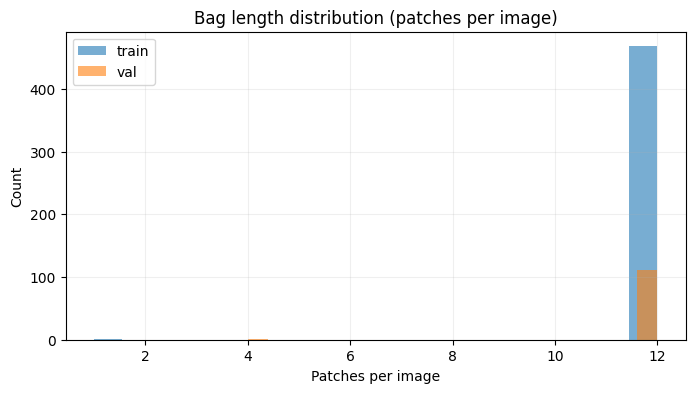

In [92]:
# ============================================================
# CELL 9B - BAG LENGTH DISTRIBUTION (MIL)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

assert "st_tr" in globals() and "en_tr" in globals()
assert "st_va" in globals() and "en_va" in globals()

len_tr = (en_tr - st_tr).astype(np.int64)
len_va = (en_va - st_va).astype(np.int64)

print("\n=== Bag lengths (patches per image) ===")
print("TRAIN bags:", len(len_tr), "| mean:", float(len_tr.mean()), "| median:", int(np.median(len_tr)), "| max:", int(len_tr.max()))
print("VAL   bags:", len(len_va), "| mean:", float(len_va.mean()), "| median:", int(np.median(len_va)), "| max:", int(len_va.max()))

plt.figure(figsize=(8,4))
plt.hist(len_tr, bins=20, alpha=0.6, label="train")
plt.hist(len_va, bins=20, alpha=0.6, label="val")
plt.title("Bag length distribution (patches per image)")
plt.xlabel("Patches per image")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [93]:
# ============================================================
# CELL 10 - GATED MIL MODEL (SAFE under autocast/float16)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler

from lion_pytorch import Lion

class GatedAttention(nn.Module):
    def __init__(self, in_dim, attn_dim):
        super().__init__()
        self.V = nn.Linear(in_dim, attn_dim)
        self.U = nn.Linear(in_dim, attn_dim)
        self.w = nn.Linear(attn_dim, 1)

    def forward(self, H, mask):
        """
        H:   [B,P,D]
        mask:[B,P] bool (True = valid)
        """
        # IMPORTANT: attention in float32 to avoid fp16 overflow
        H32 = H.float()

        V = torch.tanh(self.V(H32))
        U = torch.sigmoid(self.U(H32))
        A = self.w(V * U).squeeze(-1)  # [B,P] float32

        # safe mask fill (float32, no overflow)
        A = A.masked_fill(~mask, -1e4)  # -1e4 is enough for softmax

        alpha = torch.softmax(A, dim=1)  # float32
        return alpha  # float32

class GatedMIL(nn.Module):
    def __init__(self, emb_dim, num_classes, hid=192, attn_dim=128, drop_patch=0.25, drop_bag=0.35):
        super().__init__()
        self.patch_proj = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, hid),
            nn.GELU(),
            nn.Dropout(drop_patch),
            nn.LayerNorm(hid),
        )
        self.attn = GatedAttention(hid, attn_dim)
        self.bag_drop = nn.Dropout(drop_bag)
        self.cls = nn.Linear(hid, num_classes)

    def forward(self, X, mask):
        # X: [B,P,EMB_DIM] (maybe fp16 under autocast)
        H = self.patch_proj(X)                 # [B,P,H] (maybe fp16)
        alpha = self.attn(H, mask)             # [B,P] float32

        # weighted sum: do it in float32 then back to H dtype
        M = torch.sum(H.float() * alpha.unsqueeze(-1), dim=1)  # [B,H] float32
        M = self.bag_drop(M)
        logits = self.cls(M)                   # [B,C] float32
        return logits, alpha

def build_model():
    m = GatedMIL(EMB_DIM, NUM_CLASSES, hid=160, attn_dim=96, drop_patch=0.35, drop_bag=0.4).to(device)
    if n_gpu >= 2:
        m = nn.DataParallel(m)
        print(f"✓ DataParallel ({n_gpu} GPUs)")
    return m

def unwrap(m):
    return m.module if hasattr(m, "module") else m

scaler = GradScaler("cuda", enabled=torch.cuda.is_available())


In [94]:
# ============================================================
# CELL 10B - PRINT MODEL HEAD ARCHITECTURE (Gated MIL "quad head")
#   -> Put right after CELL 10
# ============================================================
import torch

assert "build_model" in globals()

m = build_model()
base = unwrap(m)

print("\n=== Gated MIL Head (Quad-class) Architecture ===")
print(base)

# ---- per-block parameter counts ----
def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print("\n=== Parameter breakdown (trainable) ===")
print(f"patch_proj params: {count_params(base.patch_proj):,}")
print(f"attention  params: {count_params(base.attn):,}")
print(f"classifier params: {count_params(base.cls):,}")
print(f"TOTAL      params: {count_params(base):,}")

# ---- output shapes sanity check ----
B, P, D = 2, 7, EMB_DIM
X = torch.randn(B, P, D, device=device)
mask = torch.ones(B, P, dtype=torch.bool, device=device)

with torch.no_grad():
    logits, alpha = base(X, mask)

print("\n=== Shape sanity ===")
print("Input X:", tuple(X.shape))
print("Mask   :", tuple(mask.shape))
print("Logits :", tuple(logits.shape), "-> one logit per class (4-way)")
print("Alpha  :", tuple(alpha.shape), "-> attention weight per patch (bag)")
print("Alpha sum per bag (should be ~1.0):", alpha.sum(dim=1).detach().cpu().numpy())

# cleanup
del m, base, X, mask, logits, alpha
cleanup_memory()


✓ DataParallel (2 GPUs)

=== Gated MIL Head (Quad-class) Architecture ===
GatedMIL(
  (patch_proj): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=160, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.35, inplace=False)
    (4): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
  )
  (attn): GatedAttention(
    (V): Linear(in_features=160, out_features=96, bias=True)
    (U): Linear(in_features=160, out_features=96, bias=True)
    (w): Linear(in_features=96, out_features=1, bias=True)
  )
  (bag_drop): Dropout(p=0.4, inplace=False)
  (cls): Linear(in_features=160, out_features=4, bias=True)
)

=== Parameter breakdown (trainable) ===
patch_proj params: 62,688
attention  params: 31,009
classifier params: 644
TOTAL      params: 94,341

=== Shape sanity ===
Input X: (2, 7, 384)
Mask   : (2, 7)
Logits : (2, 4) -> one logit per class (4-way)
Alpha  : (2, 7) -> attention weight per patch (bag)
Alpha

In [95]:
# ============================================================
# CELL 11 - LOSS + R-DROP + EVAL (image-level macro-F1)
# ============================================================
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

# class weights (immagini)
counts = np.bincount(yimg_tr, minlength=NUM_CLASSES).astype(np.float64)
w = counts.sum() / np.maximum(1.0, counts)
w = (w / w.mean()).astype(np.float32)
print("image counts:", counts)
print("class weights:", w)

class_w = torch.tensor(w, dtype=torch.float32, device=device)

LABEL_SMOOTH = 0.12
criterion = torch.nn.CrossEntropyLoss(weight=class_w, label_smoothing=LABEL_SMOOTH)

# R-Drop: doppio forward con dropout + KL consistency
USE_RDROP = True
RDROP_ALPHA = 0.7

EPOCHS = 70
LR = 3e-4
WEIGHT_DECAY = 2e-2
GRAD_CLIP = 1.0
PATIENCE = 18
MIN_DELTA = 0.0005

def build_optimizer(model):
    return Lion(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def build_scheduler(optimizer):
    total_steps = EPOCHS * len(train_loader)
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LR * 6.0,
        total_steps=total_steps,
        pct_start=0.10,
        anneal_strategy="cos",
        div_factor=25.0,
        final_div_factor=2000.0,
    )

@torch.no_grad()
def eval_val_f1(model, loader):
    model.eval()
    ys, ps = [], []
    for X, mask, y, _ in loader:
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits, _ = model(X, mask)
        pred = torch.argmax(logits, dim=1)

        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return float(f1_score(y_true, y_pred, average="macro"))


image counts: [124. 125. 164.  56.]
class weights: [0.8060643 0.7996158 0.6094633 1.7848567]


In [96]:
# ============================================================
# CELL 12 - TRAIN ENSEMBLE (MIL, image-level) + PRINT TRAIN_F1
# ============================================================
import os
import numpy as np
import torch
from torch.amp import autocast
import torch.nn.functional as F
from sklearn.metrics import f1_score

SEEDS = [42, 1337, 2024, 22, 37, 78]
ensemble_ckpts = []
seed_scores = {}
seed_histories = {}

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def save_ckpt(path: str, model):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(unwrap(model).state_dict(), path)

def load_ckpt_into(model, path: str):
    sd = torch.load(path, map_location=device)
    sd = {k.replace("module.", ""): v for k, v in sd.items()}
    unwrap(model).load_state_dict(sd, strict=True)
    model.eval()
    return model

@torch.no_grad()
def eval_loader_f1(model, loader):
    model.eval()
    ys, ps = [], []
    for X, mask, y, _ in loader:
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(X, mask)
        pred = torch.argmax(logits, dim=1)

        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return float(f1_score(y_true, y_pred, average="macro"))

for seed in SEEDS:
    print(f"\n==============================")
    print(f"SEED {seed}")
    print(f"==============================")
    set_seed(seed)
    cleanup_memory()

    model = build_model()
    optimizer = build_optimizer(model)
    scheduler = build_scheduler(optimizer)

    best_val = -1.0
    best_ep  = -1
    no_improve = 0
    history = {"train_loss": [], "train_f1": [], "val_f1": [], "lr": []}

    ckpt_path = os.path.join(CKPT_DIR, f"mil_gated_best_seed{seed}.pth")

    for epoch in range(EPOCHS):
        model.train()
        run_loss = 0.0
        n_seen = 0

        for X, mask, y, _ in train_loader:
            X = X.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if USE_RDROP:
                with autocast("cuda", enabled=torch.cuda.is_available()):
                    logits1, _ = model(X, mask)
                    logits2, _ = model(X, mask)

                    ce = 0.5 * (criterion(logits1, y) + criterion(logits2, y))

                    p1 = F.softmax(logits1, dim=1)
                    p2 = F.softmax(logits2, dim=1)
                    kl = 0.5 * (F.kl_div(p1.log(), p2, reduction="batchmean") +
                                F.kl_div(p2.log(), p1, reduction="batchmean"))

                    loss = ce + RDROP_ALPHA * kl
            else:
                with autocast("cuda", enabled=torch.cuda.is_available()):
                    logits, _ = model(X, mask)
                    loss = criterion(logits, y)

            scaler.scale(loss).backward()
            if GRAD_CLIP and GRAD_CLIP > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            run_loss += float(loss.item()) * y.size(0)
            n_seen += y.size(0)

        train_loss = run_loss / max(1, n_seen)

        # IMPORTANT: calcolo train_f1 in eval mode (meno rumore)
        train_f1 = eval_loader_f1(model, train_loader)
        val_f1   = eval_loader_f1(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)
        history["lr"].append(float(optimizer.param_groups[0]["lr"]))

        print(f"Epoch {epoch+1:02d} | loss={train_loss:.4f} | tr_f1={train_f1:.4f} | val_f1={val_f1:.4f}")

        if val_f1 > best_val + MIN_DELTA:
            best_val = val_f1
            best_ep = epoch
            no_improve = 0
            save_ckpt(ckpt_path, model)
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("EARLY STOP")
                break

        cleanup_memory()

    seed_histories[seed] = history
    seed_scores[seed] = best_val
    ensemble_ckpts.append(ckpt_path)
    print(f"Best seed {seed}: epoch={best_ep+1} | best_val_f1={best_val:.4f} | ckpt={ckpt_path}")

print("\nENSEMBLE CKPTS:")
for p in ensemble_ckpts:
    print(" -", p)



SEED 42
✓ DataParallel (2 GPUs)
Epoch 01 | loss=1.5601 | tr_f1=0.2499 | val_f1=0.2502
Epoch 02 | loss=1.5236 | tr_f1=0.2647 | val_f1=0.2605
Epoch 03 | loss=1.4570 | tr_f1=0.2498 | val_f1=0.2048
Epoch 04 | loss=1.4231 | tr_f1=0.3816 | val_f1=0.3181
Epoch 05 | loss=1.3842 | tr_f1=0.3477 | val_f1=0.3285
Epoch 06 | loss=1.3729 | tr_f1=0.3724 | val_f1=0.3287
Epoch 07 | loss=1.3408 | tr_f1=0.4403 | val_f1=0.3779
Epoch 08 | loss=1.3170 | tr_f1=0.4609 | val_f1=0.4158
Epoch 09 | loss=1.3036 | tr_f1=0.4174 | val_f1=0.3931
Epoch 10 | loss=1.2927 | tr_f1=0.4304 | val_f1=0.3753
Epoch 11 | loss=1.2780 | tr_f1=0.4717 | val_f1=0.4275
Epoch 12 | loss=1.2772 | tr_f1=0.4313 | val_f1=0.3913
Epoch 13 | loss=1.2627 | tr_f1=0.4157 | val_f1=0.3956
Epoch 14 | loss=1.2534 | tr_f1=0.4591 | val_f1=0.4010
Epoch 15 | loss=1.2496 | tr_f1=0.4708 | val_f1=0.4267
Epoch 16 | loss=1.2554 | tr_f1=0.4532 | val_f1=0.4061
Epoch 17 | loss=1.2373 | tr_f1=0.5662 | val_f1=0.4645
Epoch 18 | loss=1.2222 | tr_f1=0.5308 | val_f1=0.

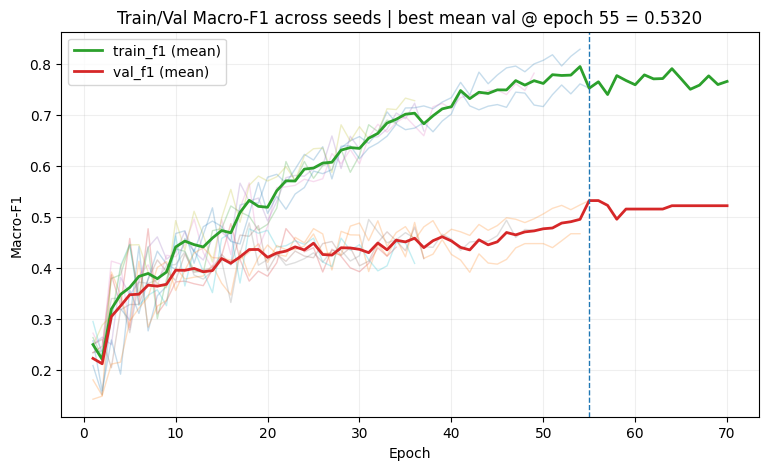

Per-seed best val_f1:
  seed 22: best=0.4893 @ ep 36
  seed 37: best=0.4869 @ ep 16
  seed 42: best=0.4830 @ ep 19
  seed 78: best=0.4951 @ ep 31
  seed 1337: best=0.4768 @ ep 18
  seed 2024: best=0.5320 @ ep 55


In [97]:
# ============================================================
# CELL 12B - PLOT TRAIN/VAL F1 (per seed + mean)
#   -> mettila subito dopo la CELL 12
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

assert "seed_histories" in globals() and len(seed_histories) > 0, "seed_histories non trovato"

# raccogli epoche (ogni seed può avere lunghezza diversa per early stop)
seeds = sorted(seed_histories.keys())
max_len = max(len(seed_histories[s]["val_f1"]) for s in seeds)

def pad(arr, L):
    arr = np.asarray(arr, dtype=np.float32)
    if len(arr) == L: 
        return arr
    out = np.full((L,), np.nan, dtype=np.float32)
    out[:len(arr)] = arr
    return out

train_mat = np.stack([pad(seed_histories[s]["train_f1"], max_len) for s in seeds], axis=0)
val_mat   = np.stack([pad(seed_histories[s]["val_f1"],   max_len) for s in seeds], axis=0)

train_mean = np.nanmean(train_mat, axis=0)
val_mean   = np.nanmean(val_mat, axis=0)

epochs = np.arange(1, max_len + 1)

plt.figure(figsize=(9,5))
for i, s in enumerate(seeds):
    plt.plot(epochs, train_mat[i], alpha=0.25, linewidth=1)
    plt.plot(epochs, val_mat[i],   alpha=0.25, linewidth=1)

plt.plot(epochs, train_mean, linewidth=2, label="train_f1 (mean)")
plt.plot(epochs, val_mean,   linewidth=2, label="val_f1 (mean)")

best_ep = int(np.nanargmax(val_mean)) + 1
best_val = float(np.nanmax(val_mean))
plt.axvline(best_ep, linestyle="--", linewidth=1)
plt.title(f"Train/Val Macro-F1 across seeds | best mean val @ epoch {best_ep} = {best_val:.4f}")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print("Per-seed best val_f1:")
for s in seeds:
    v = np.asarray(seed_histories[s]["val_f1"], dtype=np.float32)
    print(f"  seed {s}: best={float(np.nanmax(v)):.4f} @ ep {int(np.nanargmax(v))+1}")


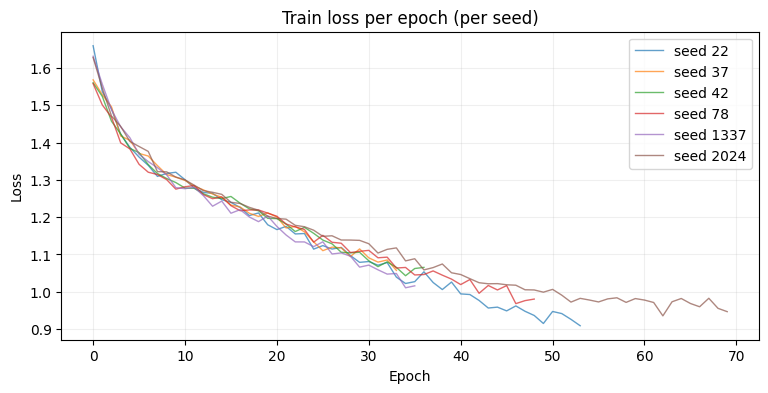

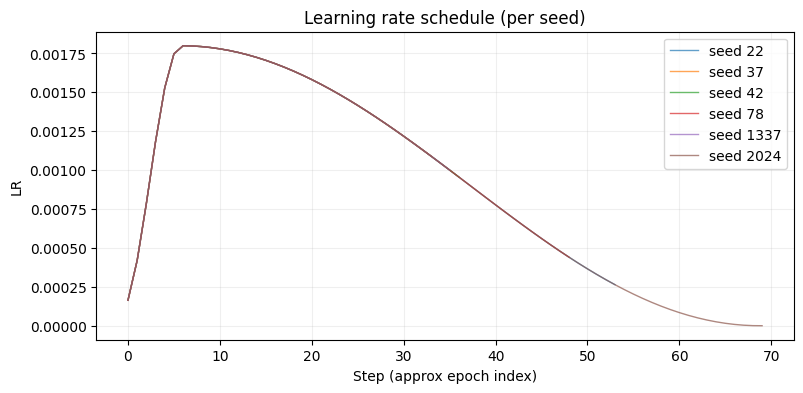

In [98]:
# ============================================================
# CELL 12C - LEARNING CURVES (LOSS + LR) PER SEED
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

assert "seed_histories" in globals()

seeds = sorted(seed_histories.keys())

plt.figure(figsize=(9,4))
for s in seeds:
    plt.plot(seed_histories[s]["train_loss"], alpha=0.7, linewidth=1, label=f"seed {s}")
plt.title("Train loss per epoch (per seed)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
for s in seeds:
    plt.plot(seed_histories[s]["lr"], alpha=0.7, linewidth=1, label=f"seed {s}")
plt.title("Learning rate schedule (per seed)")
plt.xlabel("Step (approx epoch index)")
plt.ylabel("LR")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()


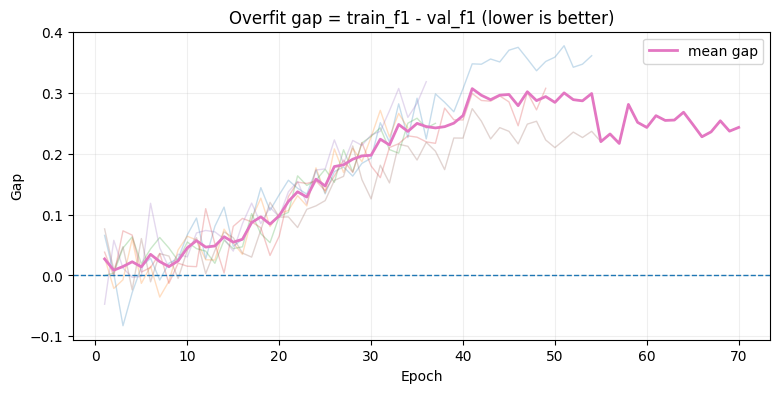

In [99]:
# ============================================================
# CELL 12D - OVERFIT GAP (train_f1 - val_f1)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

assert "seed_histories" in globals()

seeds = sorted(seed_histories.keys())
max_len = max(len(seed_histories[s]["val_f1"]) for s in seeds)

def pad_nan(x, L):
    x = np.asarray(x, dtype=np.float32)
    out = np.full((L,), np.nan, dtype=np.float32)
    out[:len(x)] = x
    return out

gap_mat = []
for s in seeds:
    tr = pad_nan(seed_histories[s]["train_f1"], max_len)
    va = pad_nan(seed_histories[s]["val_f1"],   max_len)
    gap_mat.append(tr - va)
gap_mat = np.stack(gap_mat, axis=0)

gap_mean = np.nanmean(gap_mat, axis=0)
epochs = np.arange(1, max_len+1)

plt.figure(figsize=(9,4))
for i, s in enumerate(seeds):
    plt.plot(epochs, gap_mat[i], alpha=0.25, linewidth=1)
plt.plot(epochs, gap_mean, linewidth=2, label="mean gap")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("Overfit gap = train_f1 - val_f1 (lower is better)")
plt.xlabel("Epoch")
plt.ylabel("Gap")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
                 precision    recall  f1-score   support

        HER2(+)     0.3448    0.3846    0.3636        26
      Luminal A     0.6071    0.5152    0.5574        33
      Luminal B     0.5294    0.4500    0.4865        40
Triple negative     0.3333    0.5385    0.4118        13

       accuracy                         0.4643       112
      macro avg     0.4537    0.4721    0.4548       112
   weighted avg     0.4867    0.4643    0.4702       112



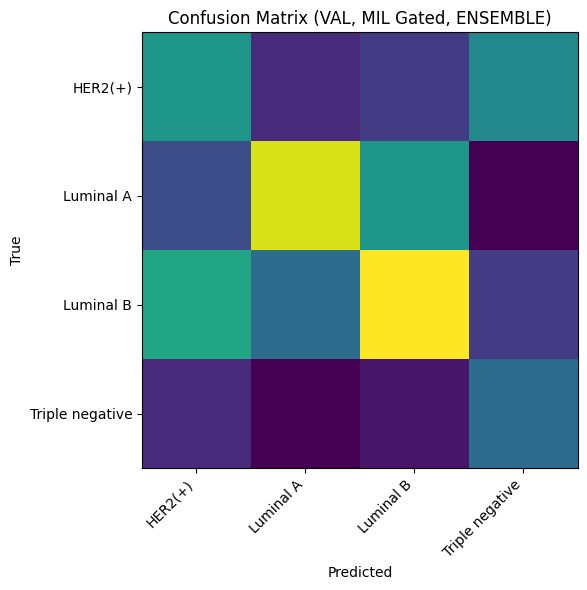

In [100]:
# ============================================================
# CELL 13 - ENSEMBLE EVAL (VAL) + CONFUSION
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def predict_ensemble(model_paths, loader):
    models = []
    for p in model_paths:
        m = build_model()
        m = load_ckpt_into(m, p)
        m.eval()
        models.append(m)

    y_true_all, y_pred_all = [], []
    for X, mask, y, _ in loader:
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)

        lg_acc = None
        for m in models:
            logits, _ = m(X, mask)
            lg_acc = logits if lg_acc is None else (lg_acc + logits)
        logits = lg_acc / len(models)

        pred = torch.argmax(logits, dim=1).detach().cpu().numpy()
        y_true_all.append(y.numpy())
        y_pred_all.append(pred)

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    return y_true, y_pred

y_true, y_pred = predict_ensemble(ensemble_ckpts, val_loader)
target_names = [id2label[i] for i in range(NUM_CLASSES)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (VAL, MIL Gated, ENSEMBLE)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(NUM_CLASSES), target_names, rotation=45, ha="right")
plt.yticks(np.arange(NUM_CLASSES), target_names)
plt.tight_layout()
plt.show()


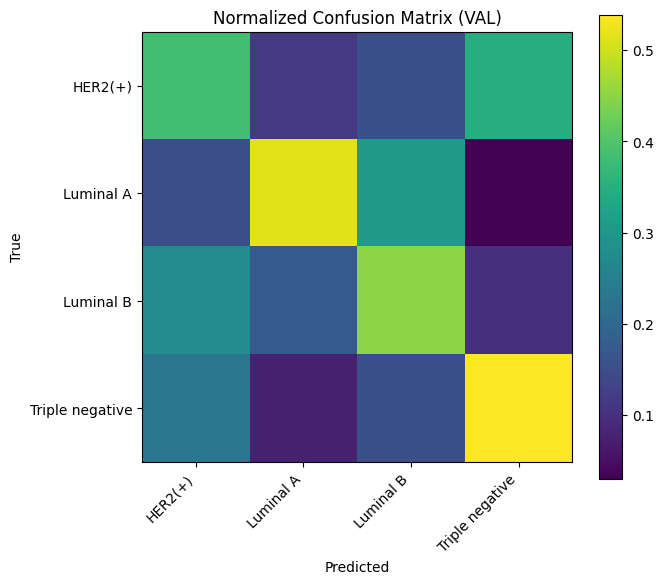

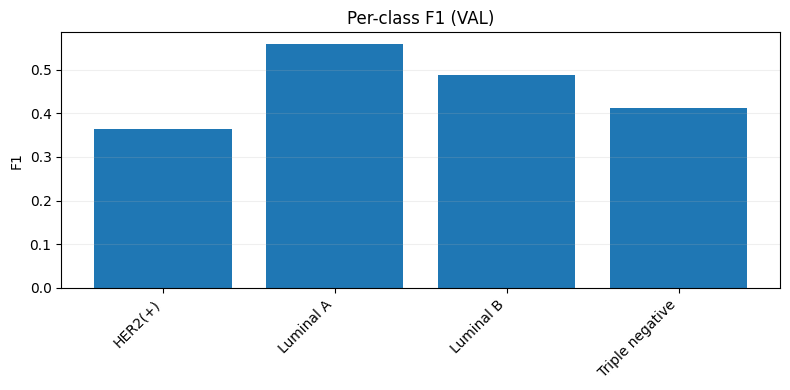


Per-class F1:
  0 (HER2(+)): 0.3636
  1 (Luminal A): 0.5574
  2 (Luminal B): 0.4865
  3 (Triple negative): 0.4118


In [101]:
# ============================================================
# CELL 13B - NORMALIZED CONFUSION + PER-CLASS F1 BAR
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

assert "y_true" in globals() and "y_pred" in globals()

labels = list(range(NUM_CLASSES))
cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_norm = cm / np.maximum(1, cm.sum(axis=1, keepdims=True))

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (VAL)")
plt.xlabel("Predicted")
plt.ylabel("True")
names = [id2label[i] for i in labels]
plt.xticks(np.arange(NUM_CLASSES), names, rotation=45, ha="right")
plt.yticks(np.arange(NUM_CLASSES), names)
plt.colorbar()
plt.tight_layout()
plt.show()

per_class_f1 = f1_score(y_true, y_pred, average=None, labels=labels)

plt.figure(figsize=(8,4))
plt.bar(np.arange(NUM_CLASSES), per_class_f1)
plt.xticks(np.arange(NUM_CLASSES), names, rotation=45, ha="right")
plt.title("Per-class F1 (VAL)")
plt.ylabel("F1")
plt.grid(True, axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

print("\nPer-class F1:")
for i, f in enumerate(per_class_f1):
    print(f"  {i} ({id2label[i]}): {float(f):.4f}")


In [102]:
# ============================================================
# CELL 13C - VAL UNCERTAINTY (ENTROPY) + HARD CASES TABLE
# ============================================================
import numpy as np
import pandas as pd
import torch
from torch.amp import autocast

assert "ensemble_ckpts" in globals()
assert "val_loader" in globals()
assert "val_df2" in globals()

@torch.no_grad()
def val_probs_ensemble(ckpt_paths, loader, num_images):
    models = []
    for p in ckpt_paths:
        m = build_model()
        m = load_ckpt_into(m, p)
        m.eval()
        models.append(m)

    probs = np.zeros((num_images, NUM_CLASSES), dtype=np.float64)
    ytrue = np.full((num_images,), -1, dtype=np.int64)

    for X, mask, y, idx in loader:
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)
        idx_np = idx.numpy().astype(np.int64)

        lg_acc = None
        for m in models:
            with autocast("cuda", enabled=torch.cuda.is_available()):
                logits, _ = m(X, mask)
            lg_acc = logits if lg_acc is None else (lg_acc + logits)
        logits = lg_acc / len(models)

        p = torch.softmax(logits.float(), dim=1).cpu().numpy()
        probs[idx_np] = p
        ytrue[idx_np] = y.numpy().astype(np.int64)

    return probs, ytrue

probs_va, ytrue_va = val_probs_ensemble(ensemble_ckpts, val_loader, num_val_images)
pred_va = probs_va.argmax(axis=1).astype(np.int64)

eps = 1e-12
entropy = -(probs_va * np.log(probs_va + eps)).sum(axis=1)  # higher = more uncertain

val_files = val_df2[IMG_COL].astype(str).tolist()
df_hard = pd.DataFrame({
    "file": val_files,
    "true": [id2label[i] for i in ytrue_va],
    "pred": [id2label[i] for i in pred_va],
    "entropy": entropy,
    "p_max": probs_va.max(axis=1)
})

df_wrong = df_hard[df_hard["true"] != df_hard["pred"]].sort_values("entropy", ascending=False)
df_unc   = df_hard.sort_values("entropy", ascending=False)

print("\nTop-15 most uncertain (VAL):")
display(df_unc.head(15))

print("\nTop-15 wrong & most uncertain (VAL):")
display(df_wrong.head(15))


✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)
✓ DataParallel (2 GPUs)

Top-15 most uncertain (VAL):


,file,true,pred,entropy,p_max
78,img_0207.png,HER2(+),HER2(+),1.381380,0.279386
23,img_0225.png,Triple negative,HER2(+),1.376440,0.290054
9,img_0370.png,Triple negative,Luminal B,1.374302,0.315335
7,img_0636.png,Luminal A,HER2(+),1.372504,0.293949
62,img_0338.png,Luminal B,Luminal A,1.368213,0.321943
0,img_0086.png,Triple negative,Luminal B,1.345000,0.347094
2,img_0220.png,HER2(+),Luminal B,1.344062,0.359892
20,img_0369.png,Luminal B,HER2(+),1.342575,0.337243
72,img_0266.png,Luminal B,Luminal B,1.340898,0.320581
36,img_0326.png,HER2(+),Triple negative,1.334875,0.330634



Top-15 wrong & most uncertain (VAL):


,file,true,pred,entropy,p_max
23,img_0225.png,Triple negative,HER2(+),1.376440,0.290054
9,img_0370.png,Triple negative,Luminal B,1.374302,0.315335
7,img_0636.png,Luminal A,HER2(+),1.372504,0.293949
62,img_0338.png,Luminal B,Luminal A,1.368213,0.321943
0,img_0086.png,Triple negative,Luminal B,1.345000,0.347094
2,img_0220.png,HER2(+),Luminal B,1.344062,0.359892
20,img_0369.png,Luminal B,HER2(+),1.342575,0.337243
36,img_0326.png,HER2(+),Triple negative,1.334875,0.330634
26,img_0608.png,Luminal B,Luminal A,1.319462,0.338339
1,img_0382.png,Luminal B,Luminal A,1.310148,0.375629


✓ DataParallel (2 GPUs)


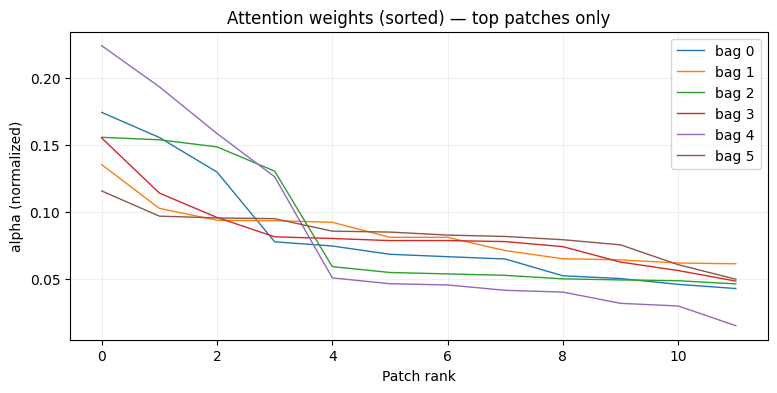


Examples (idx, true, pred, p_max):
  idx=0 | true=Triple negative | pred=Luminal A | p_max=0.323 | patches=12
  idx=1 | true=Luminal B | pred=Luminal A | p_max=0.360 | patches=12
  idx=2 | true=HER2(+) | pred=Luminal B | p_max=0.290 | patches=12
  idx=3 | true=Luminal A | pred=Luminal A | p_max=0.517 | patches=12
  idx=4 | true=Triple negative | pred=Triple negative | p_max=0.503 | patches=12
  idx=5 | true=Triple negative | pred=Triple negative | p_max=0.406 | patches=12


In [103]:
# ============================================================
# CELL 13D - ATTENTION DIAGNOSTICS (alpha concentration)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.amp import autocast

assert "ensemble_ckpts" in globals()

# load best single model (first ckpt) for attention visualization
att_model = build_model()
att_model = load_ckpt_into(att_model, ensemble_ckpts[0])
att_model.eval()

@torch.no_grad()
def get_alpha_for_some(loader, n_batches=1):
    alphas = []
    infos = []
    for bi, batch in enumerate(loader):
        if bi >= n_batches:
            break
        X, mask, y, idx = batch
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)

        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits, alpha = att_model(X, mask)

        probs = torch.softmax(logits.float(), dim=1).cpu().numpy()
        alpha = alpha.cpu().numpy()
        mask_np = mask.cpu().numpy()
        y_np = y.numpy()
        idx_np = idx.numpy()

        for i in range(alpha.shape[0]):
            a = alpha[i][mask_np[i]]
            alphas.append(a)
            infos.append((int(idx_np[i]), int(y_np[i]), int(probs[i].argmax()), float(probs[i].max())))
    return alphas, infos

alphas, infos = get_alpha_for_some(val_loader, n_batches=2)

# plot: attention concentration for first 6 bags
k = min(6, len(alphas))
plt.figure(figsize=(9,4))
for i in range(k):
    a = np.sort(alphas[i])[::-1]
    a = a / (a.sum() + 1e-12)
    plt.plot(a[:min(40, len(a))], linewidth=1, label=f"bag {i}")
plt.title("Attention weights (sorted) — top patches only")
plt.xlabel("Patch rank")
plt.ylabel("alpha (normalized)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

print("\nExamples (idx, true, pred, p_max):")
for i in range(k):
    idx_i, y_t, y_p, pmax = infos[i]
    print(f"  idx={idx_i} | true={id2label[y_t]} | pred={id2label[y_p]} | p_max={pmax:.3f} | patches={len(alphas[i])}")


In [104]:

# ============================================================
# CELL 14 - TEST FILE LIST + DEDUP " 2"
# ============================================================
all_files = [f for f in os.listdir(TEST_IMAGES_ROOT) if os.path.isfile(os.path.join(TEST_IMAGES_ROOT, f))]

present = set(all_files)
pat = re.compile(r"^(.*)\s(\d+)(\.\w+)$")

kept = []
dup_removed = 0
for f in all_files:
    m = pat.match(f)
    if m:
        base, k, ext = m.group(1), m.group(2), m.group(3)
        base_name = base + ext
        if base_name in present:
            dup_removed += 1
            continue
    kept.append(f)

test_files = sorted(list(dict.fromkeys(kept)))
print(f"Test files: {len(all_files)} -> kept {len(test_files)} | removed duplicates: {dup_removed}")
test_df = pd.DataFrame({IMG_COL: test_files})


Test files: 477 -> kept 477 | removed duplicates: 0


In [ ]:

# ============================================================
# CELL 15 - EXTRACT TEST EMBEDDINGS (PATCH-LEVEL) + CACHE
# ============================================================
test_df2, test_coords = build_patch_index(
    test_df, TEST_IMAGES_ROOT, IMG_COL,
    patch_size=PATCH_SIZE, stride=PATCH_STRIDE, drop_last_patch=DROP_LAST_PATCH,
    use_black_filter=USE_BLACK_FILTER, topk=TOPK_IF_TOO_MANY, force_one=True
)
num_test_images = len(test_df2)

if not os.path.isfile(TEST_EMB_PATH):
    extract_and_cache(test_df2, test_coords, TEST_IMAGES_ROOT, TEST_EMB_PATH,
                      has_labels=False, apply_aug=False, seed=SEED)
else:
    print("Using cached:", TEST_EMB_PATH)


[build_patch_index] images: 477 | patches kept: 5713
[build_patch_index] black dropped: 33235/59238 (56.1%)
[build_patch_index] fallback forced 1 patch for 1 images


Extract -> test_embeddings.npz:   0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
# ============================================================
# CELL 15B - BUILD TEST BAG LOADER (MIL)
# ============================================================
assert os.path.isfile(TEST_EMB_PATH), f"Missing cached embeddings: {TEST_EMB_PATH}"
te = np.load(TEST_EMB_PATH, allow_pickle=True)

Xte = te["feats"].astype(np.float32)
idte = te["img_ids"].astype(np.int64)

# segments per test image
order = np.argsort(idte)
Xte_s = Xte[order]
idte_s = idte[order]
uniq, st = np.unique(idte_s, return_index=True)
st = st.astype(np.int64)
en = np.r_[st[1:], np.array([len(idte_s)], dtype=np.int64)]

num_test_images = len(uniq)
print("Test images:", num_test_images, "| Test patches:", Xte.shape[0])

test_bag_ds = BagEmbDataset(Xte_s, st, en, y_img=None, train_mode=False, seed=SEED)

test_loader = DataLoader(
    test_bag_ds,
    batch_size=BATCH_SIZE_BAG,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_bags
)

print("✓ test_loader ready | batches:", len(test_loader))


In [ ]:
# ============================================================
# CELL 16 - TEST INFERENCE (MIL ENSEMBLE) + SUBMISSION
# ============================================================
import numpy as np
import pandas as pd

@torch.no_grad()
def predict_test_probs_ensemble(ckpt_paths, loader, num_images):
    models = []
    for p in ckpt_paths:
        m = build_model()
        m = load_ckpt_into(m, p)
        m.eval()
        models.append(m)

    probs = np.zeros((num_images, NUM_CLASSES), dtype=np.float64)

    for X, mask, idx in loader:
        X = X.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)
        idx_np = idx.numpy().astype(np.int64)

        lg_acc = None
        for m in models:
            logits, _ = m(X, mask)
            lg_acc = logits if lg_acc is None else (lg_acc + logits)
        logits = lg_acc / len(models)

        p = torch.softmax(logits, dim=1).detach().cpu().numpy()
        probs[idx_np] = p

    return probs

probs_img = predict_test_probs_ensemble(ensemble_ckpts, test_loader, num_test_images)
pred_id = np.argmax(probs_img, axis=1).astype(int)
pred_lbl = [id2label[i] for i in pred_id]

# ATTENZIONE: qui uso test_df2 già creato prima (CELL 15)
sub_df = pd.DataFrame({IMG_COL: test_df2[IMG_COL].astype(str).tolist(),
                       LABEL_COL: pred_lbl}).sort_values(IMG_COL).reset_index(drop=True)

sub_df.to_csv(SUBMISSION_PATH, index=False)
print("Saved submission:", SUBMISSION_PATH)
print(sub_df[LABEL_COL].value_counts())
display(sub_df.head())
